In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.44 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6013.4/8062.4 GB disk)


In [2]:
!cp -r '/kaggle/input/shale-shaker/train' /kaggle/working/
!cp -r '/kaggle/input/shale-shaker/valid' /kaggle/working/
!cp -r '/kaggle/input/shale-shaker/data.yaml' /kaggle/working


In [15]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import os
import glob

In [3]:
from ultralytics import YOLO
model = YOLO('yolo11m-seg.pt')

100%|██████████| 43.3M/43.3M [00:00<00:00, 224MB/s]


In [5]:
video_path = '/kaggle/input/shale-shaker/Cavings.mp4'

In [8]:
!yolo task=detect mode=predict model='/kaggle/input/shale-shaker/caving.pt' source = '/kaggle/input/shale-shaker/Cavings.mp4' save_txt=True

In [27]:
import os
import numpy as np
import pandas as pd
from shapely.geometry import Polygon

def parse_polygon_data(txt_line):
    """
    Parse a single line of YOLOv8 segmentation output.
    """
    data = list(map(float, txt_line.split()))
    # The first column is ignored, as we assign sequential IDs instead
    coordinates = np.array(data[1:]).reshape(-1, 2)  # Reshape into pairs of (x, y)
    return coordinates

def calculate_polygon_properties(coordinates):
    """
    Calculate area, perimeter, major axis, roundness, and circularity of a polygon.
    """
    if len(coordinates) < 3:
        # Handle invalid polygons gracefully
        return 0, 0, 0, 0, 0  # Return zero values if the polygon is invalid
    
    polygon = Polygon(coordinates)
    
    # Area
    area = polygon.area
    
    # Perimeter
    perimeter = polygon.length
    
    # Major Axis (approximation: distance between farthest points)
    coords = np.array(coordinates)
    distances = np.sqrt(((coords[:, np.newaxis] - coords) ** 2).sum(axis=2))
    major_axis = np.max(distances)
    
    # Roundness
    roundness = 4 * area / (np.pi * (major_axis**2)) if major_axis > 0 else 0
    
    # Circularity
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0
    
    return area, perimeter, major_axis, roundness, circularity

# Directory containing TXT files
directory_path = "/kaggle/working/runs/segment/predict2/labels/"

# Initialize a list to store results
all_results = []

# Iterate through all TXT files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory_path, filename)
        
        # Read and process each line in the file
        with open(file_path, "r") as file:
            lines = file.readlines()

        for i, line in enumerate(lines):
            coordinates = parse_polygon_data(line)
            area, perimeter, major_axis, roundness, circularity = calculate_polygon_properties(coordinates)
            
            # Append results to the list, assign sequential caving_id starting from 1
            all_results.append({
                "filename": filename,
                "caving_id": i + 1,  # Sequential ID starting from 1
                "area": area,
                "perimeter": perimeter,
                "major_axis": major_axis,
                "roundness": roundness,
                "circularity": circularity
            })

# Convert the list of results to a pandas DataFrame
df = pd.DataFrame(all_results)

# Display the DataFrame
print(df)

# Optionally, save the DataFrame to a CSV file
df.to_csv("polygon_properties_with_shape_factors.csv", index=False)


              filename  caving_id      area  perimeter  major_axis  roundness  \
0      Cavings_379.txt          1  0.005321   0.346977    0.140367   0.343867   
1      Cavings_379.txt          2  0.005388   0.306587    0.118669   0.487192   
2      Cavings_379.txt          3  0.002556   0.235838    0.090115   0.400818   
3      Cavings_379.txt          4  0.003865   0.291632    0.112750   0.387105   
4      Cavings_379.txt          5  0.004030   0.311546    0.124734   0.329793   
...                ...        ...       ...        ...         ...        ...   
6800  Cavings_1560.txt          2  0.004110   0.316792    0.122362   0.349531   
6801  Cavings_1560.txt          3  0.005636   0.337539    0.117455   0.520142   
6802  Cavings_1560.txt          4  0.011717   0.661250    0.192941   0.400735   
6803  Cavings_2462.txt          1  0.003941   0.265477    0.095645   0.548521   
6804  Cavings_2462.txt          2  0.006736   0.350252    0.127722   0.525762   

      circularity  
0      

In [40]:
# Ensure the DataFrame (df) is sorted by filename in numerical order
df = df.sort_values(by='filename', key=lambda x: x.str.extract('(\d+)').squeeze().astype(int))  # Flatten the array

df

,filename,caving_id,area,perimeter,major_axis,roundness,circularity
4575,Cavings_1.txt,4,0.000836,0.140416,0.054619,0.356597,0.532520
4572,Cavings_1.txt,1,0.001183,0.153734,0.056552,0.470870,0.628859
4587,Cavings_1.txt,16,0.001547,0.168541,0.062985,0.496606,0.684512
4574,Cavings_1.txt,3,0.001734,0.213332,0.087517,0.288248,0.478784
4586,Cavings_1.txt,15,0.000467,0.107997,0.043975,0.307194,0.502693
...,...,...,...,...,...,...,...
5084,Cavings_2851.txt,1,0.002068,0.189743,0.065660,0.610773,0.721856
5298,Cavings_2852.txt,1,0.002068,0.189743,0.065660,0.610773,0.721856
2753,Cavings_2853.txt,1,0.002068,0.189743,0.065660,0.610773,0.721856
6279,Cavings_2854.txt,1,0.002068,0.189743,0.065660,0.610773,0.721856


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the roundness range
roundness_range = np.linspace(0, 1, 500)

# Define the curves (adjusted to be non-decreasing)
red_curve = 0.5 + 0.25 * roundness_range**0.5
green_curve = 0.1 + 0.15 * roundness_range**0.5

# Get unique filenames from the DataFrame
unique_files = df['filename'].unique()

# Initialize the figure
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    """
    Update function for each frame in the animation.
    """
    ax.clear()  # Clear previous frame
    
    # Filter data for the current file
    current_file = unique_files[frame]
    current_data = df[df['filename'] == current_file]
    print(f"Processing: {current_file}")  # Print progress
    
    # Plot the classification curves
    ax.plot(roundness_range, red_curve, color='red', label='Bedding Failure')
    ax.plot(roundness_range, green_curve, color='green', label='Tensile Failure')
    
    # Fill areas for different regions
    ax.fill_between(roundness_range, red_curve, 1, color='red', alpha=0.2, label='Bedding Failure Region')
    ax.fill_between(roundness_range, green_curve, red_curve, color='gray', alpha=0.2, label='Shear Failure Region')
    ax.fill_between(roundness_range, 0, green_curve, color='green', alpha=0.2, label='Tensile Failure Region')
    
    # Plot data points for the current file
    ax.scatter(current_data['roundness'], current_data['circularity'], color='blue', alpha=0.6, label='Polygon Data')
    
    # Set labels and title
    ax.set_xlabel('Roundness', fontsize=12)
    ax.set_ylabel('Circularity', fontsize=12)
    ax.set_title(f'Failure Region Classification: {current_file}', fontsize=14)
    ax.legend()
    ax.grid(True)

# Create the animation
animation = FuncAnimation(fig, update, frames=len(unique_files), repeat=False)

# Save the animation as a video (MP4)
animation.save('failure_regions_animation.mp4', writer='ffmpeg', fps=2)

# Display the animation (for inline Jupyter Notebook or local visualization)
plt.show()


In [34]:
df.filename.unique(

)

array(['Cavings_1.txt', 'Cavings_100.txt', 'Cavings_1000.txt', ..., 'Cavings_997.txt', 'Cavings_998.txt', 'Cavings_999.txt'], dtype=object)

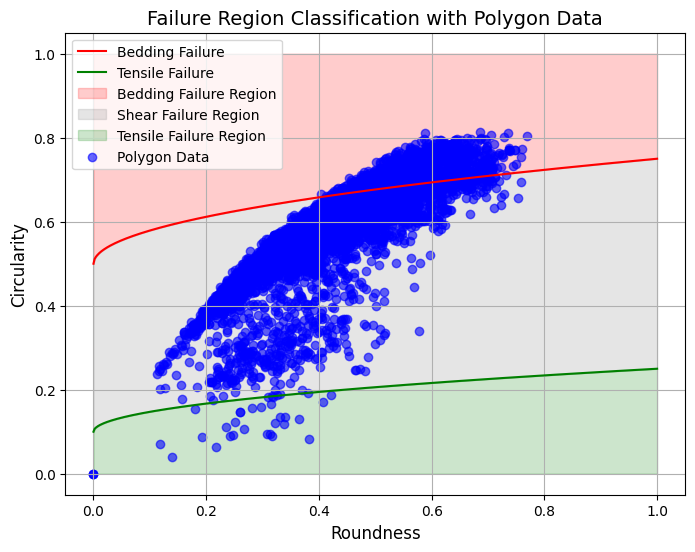

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the roundness range
roundness_range = np.linspace(0, 1, 500)

# Define the curves (adjusted to be non-decreasing)
red_curve = 0.5 + 0.25 * roundness_range**0.5
green_curve = 0.1 + 0.15 * roundness_range**0.5

# Plot the classification curves
plt.figure(figsize=(8, 6))
plt.plot(roundness_range, red_curve, color='red', label='Bedding Failure')
plt.plot(roundness_range, green_curve, color='green', label='Tensile Failure')

# Fill areas for different regions
plt.fill_between(roundness_range, red_curve, 1, color='red', alpha=0.2, label='Bedding Failure Region')
plt.fill_between(roundness_range, green_curve, red_curve, color='gray', alpha=0.2, label='Shear Failure Region')
plt.fill_between(roundness_range, 0, green_curve, color='green', alpha=0.2, label='Tensile Failure Region')

# Extract roundness and circularity data from DataFrame
roundness_data = df['roundness']
circularity_data = df['circularity']

# Overlay scatter points from the DataFrame
plt.scatter(roundness_data, circularity_data, color='blue', label='Polygon Data', alpha=0.6)

# Add labels, title, and legend
plt.xlabel('Roundness', fontsize=12)
plt.ylabel('Circularity', fontsize=12)
plt.title('Failure Region Classification with Polygon Data', fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [4]:
results = model.train(data='/kaggle/working/data.yaml', epochs=100, imgsz=640)

Ultralytics 8.3.44 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<00:00, 584.99it/s]

train: New cache created: /kaggle/working/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/valid/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 581.90it/s]

val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.3G      3.226      4.939      4.181       1.99        346        640: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all          2         36          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.3G      3.102      4.622      4.012      1.836        401        640: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]

                   all          2         36      0.222      0.556      0.172     0.0677      0.178      0.472      0.138     0.0502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.2G      1.742      3.016      1.852      1.142        257        640: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]

                   all          2         36        0.3      0.583      0.379      0.179       0.27      0.528      0.374      0.168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.1G      1.625      2.571      1.311      1.109        261        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          2         36      0.156      0.722      0.279      0.138      0.162       0.75      0.311      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.4G      1.526      2.331      1.304      1.088        296        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

                   all          2         36       0.12      0.679      0.104     0.0399      0.119      0.611      0.101     0.0354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.3G      1.467      2.282       1.15      1.083        187        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all          2         36     0.0989        0.5     0.0661      0.034     0.0967      0.472     0.0627     0.0278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100        12G      1.475      2.277      1.128      1.037        237        640: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]

                   all          2         36      0.067      0.333     0.0379     0.0169     0.0502       0.25     0.0265     0.0137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.2G      1.473      2.304      1.087       1.06        216        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all          2         36      0.073     0.0556     0.0137    0.00712      0.073     0.0556     0.0137    0.00525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.3G      1.379      2.116      1.024      1.046        284        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all          2         36      0.188      0.222     0.0867     0.0443      0.166      0.222      0.072     0.0299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.5G      1.384      1.981      1.057      1.041        243        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

                   all          2         36      0.362        0.5      0.424      0.196      0.588      0.357      0.404      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.5G      1.431      2.185     0.9992      1.001        349        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all          2         36      0.365      0.333      0.251      0.108      0.396      0.361      0.264     0.0867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.4G      1.452      2.076     0.9581      1.007        284        640: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all          2         36      0.395      0.399      0.291      0.156      0.497      0.361        0.3      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.2G      1.315      2.002      0.936      0.995        272        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


                   all          2         36      0.693      0.333      0.404       0.24      0.595      0.327      0.364      0.158

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.2G      1.246      1.763     0.9297     0.9763        232        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all          2         36      0.433      0.417      0.439      0.247      0.333        0.5      0.387      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.3G      1.246      1.754     0.8338     0.9788        241        640: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]

                   all          2         36      0.222      0.417       0.15     0.0704      0.223      0.611      0.164     0.0528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.4G      1.316       1.88      1.013     0.9852        399        640: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all          2         36      0.164      0.417      0.106      0.044      0.153      0.389     0.0985     0.0397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.1G      1.262       1.79     0.8767     0.9844        232        640: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all          2         36      0.167      0.389      0.112     0.0543      0.127      0.472     0.0972     0.0392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.3G      1.305      2.018     0.8613      0.973        257        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all          2         36      0.138        0.5      0.102     0.0479      0.132      0.417     0.0833     0.0349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.9G      1.314      1.886      0.862      1.001        261        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all          2         36      0.086        0.5     0.0624     0.0287      0.086        0.5     0.0564     0.0217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.1G      1.253      1.789     0.8231     0.9711        223        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all          2         36       0.17      0.417      0.129     0.0632      0.161      0.389       0.11     0.0441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.4G      1.233      1.663     0.8147     0.9602        361        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]

                   all          2         36      0.246      0.444      0.195     0.0998      0.246      0.444       0.19     0.0733



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.1G      1.175      1.801     0.8932     0.9581        216        640: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]

                   all          2         36      0.457      0.333      0.376      0.208      0.427      0.278      0.284      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100        12G      1.146      1.789     0.8004     0.9907        188        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all          2         36      0.342      0.306      0.234      0.104      0.342      0.306      0.203     0.0698



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.4G      1.301      1.815     0.8976      1.001        219        640: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]

                   all          2         36      0.466      0.558      0.446      0.224      0.427      0.518        0.4      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.4G      1.194      1.643        0.8     0.9478        248        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

                   all          2         36      0.436      0.611      0.457      0.219       0.42      0.444      0.397      0.178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.5G       1.25      1.646     0.8001     0.9692        225        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all          2         36      0.442        0.5      0.455      0.244        0.4      0.472      0.415      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      12.3G      1.183      1.757     0.7761      0.947        215        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all          2         36      0.518      0.361      0.366      0.181      0.544      0.331      0.343      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      12.4G      1.106      1.535     0.7421     0.9562        162        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]

                   all          2         36      0.441      0.569      0.419      0.219      0.441      0.569      0.408      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      12.2G      1.127      1.473     0.7258     0.9291        330        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]

                   all          2         36       0.43      0.389      0.361      0.173       0.38      0.361      0.315      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.2G      1.151       1.56     0.7289     0.9634        208        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all          2         36      0.478      0.444      0.435      0.209      0.478      0.444      0.426      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      12.3G      1.166      1.634     0.7323     0.9534        237        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all          2         36      0.417      0.438       0.43       0.22      0.625      0.361      0.436      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100        12G      1.127      1.638     0.7331     0.9186        297        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


                   all          2         36      0.405      0.417      0.392      0.205      0.405      0.417      0.387      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.3G      1.032      1.414     0.7121     0.9178        115        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]

                   all          2         36      0.432      0.528      0.451      0.191      0.473      0.444      0.449      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      12.4G      1.173       1.44     0.7173     0.9444        423        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


                   all          2         36      0.734      0.417       0.47      0.227      0.683      0.389      0.412       0.18

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.4G      1.057       1.47     0.6445     0.9194        155        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all          2         36      0.655      0.444      0.507      0.237      0.414      0.444        0.4      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.4G      1.031      1.348     0.6244       0.93        214        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all          2         36      0.508      0.583      0.467      0.203      0.483      0.556      0.409      0.157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      12.2G     0.9758      1.278     0.6091     0.8869        371        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all          2         36      0.448      0.609      0.487      0.213       0.46        0.5      0.406      0.151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.2G      1.147      1.591      0.664     0.9159        161        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all          2         36       0.44      0.632      0.488      0.248      0.577      0.444      0.443      0.178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.1G       1.03      1.344     0.6326     0.8829        292        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all          2         36      0.567      0.528      0.484      0.215      0.536        0.5      0.441      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.4G      1.014      1.365     0.6237     0.9073        338        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]

                   all          2         36      0.586      0.551       0.51      0.237      0.586      0.551      0.498      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.1G     0.9442        1.3     0.5861     0.8796        278        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all          2         36      0.591        0.5      0.472      0.235      0.591        0.5      0.441      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.1G      1.047      1.322     0.6063     0.8933        311        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]

                   all          2         36      0.679      0.444      0.489      0.209      0.723      0.472      0.512      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.1G     0.9629      1.292     0.6056     0.8817        248        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]

                   all          2         36      0.505      0.528      0.497      0.233      0.477        0.5      0.464      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.1G     0.9891      1.274     0.6032     0.9089        267        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all          2         36      0.507      0.611      0.492       0.25      0.708      0.389      0.495      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.5G     0.9609      1.238     0.5789     0.8791        233        640: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all          2         36      0.575      0.556      0.496      0.237      0.527      0.528      0.475       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.2G     0.9312      1.257     0.5464     0.8814        235        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]

                   all          2         36      0.535      0.556      0.452      0.204      0.563      0.583      0.481       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.7G     0.8374      1.143     0.5227     0.8723        203        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all          2         36      0.454      0.528      0.484      0.247      0.479      0.472      0.434      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100        12G     0.9161      1.248     0.6228     0.8776        192        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]

                   all          2         36      0.688      0.551      0.552      0.259      0.653      0.528      0.505      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.1G     0.8441      1.159     0.5119     0.8658        281        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all          2         36        0.6        0.5      0.511      0.255        0.6        0.5      0.478      0.215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.9G     0.8659      1.179     0.5238     0.8658        202        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all          2         36       0.74        0.5      0.563      0.262      0.698      0.472      0.513      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.3G     0.8771      1.189     0.5751     0.8521        383        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


                   all          2         36      0.557      0.594      0.563      0.257      0.486        0.5      0.433      0.222

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.4G     0.8271      1.124      0.501     0.8441        219        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all          2         36      0.544      0.611      0.507       0.25      0.518      0.583      0.487      0.234

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      12.3G     0.9195      1.246     0.6243      0.878        126        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all          2         36      0.515      0.583      0.447      0.214      0.515      0.583      0.436      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.2G     0.8763      1.181     0.5808     0.8769        262        640: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]

                   all          2         36       0.57      0.528      0.478       0.21       0.54        0.5      0.432      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.2G     0.9698      1.274     0.5399     0.8794        259        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]

                   all          2         36      0.541        0.5      0.478       0.24      0.618        0.5      0.522      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.6G     0.8969       1.13     0.5841     0.8611        247        640: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

                   all          2         36      0.702      0.417      0.506      0.289      0.749      0.444      0.555      0.248



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.2G     0.8559      1.254      0.521      0.867        241        640: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all          2         36      0.668      0.472      0.543      0.292      0.779      0.444      0.545      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.2G     0.8848      1.141     0.5195     0.8661        304        640: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]

                   all          2         36      0.757      0.472      0.571      0.295      0.506      0.611      0.529      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      12.1G     0.8708      1.195     0.5329     0.8542        335        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


                   all          2         36      0.766        0.5       0.57      0.299      0.723      0.472      0.547      0.226

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      12.3G     0.8524      1.172     0.5154     0.8666        248        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all          2         36      0.634      0.583      0.606      0.313      0.599      0.556      0.556       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      12.3G     0.8139      1.074     0.4958     0.8641        211        640: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.21it/s]

                   all          2         36      0.857      0.417      0.558      0.276      0.797      0.389      0.516      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.1G     0.8087      1.068     0.4795     0.8509        259        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all          2         36      0.876      0.444      0.549      0.266      0.833      0.416       0.51      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      12.1G     0.8218      1.021     0.4882     0.8495        249        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all          2         36      0.808      0.444      0.535      0.265      0.761      0.417      0.518      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.4G     0.7736     0.9792     0.4776     0.8522        207        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all          2         36      0.737      0.468      0.546      0.272      0.737      0.468      0.593      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      12.2G     0.8515      1.024     0.4838     0.8493        316        640: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]

                   all          2         36      0.736        0.5      0.555      0.262      0.736        0.5      0.597      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100        12G     0.7947     0.9895     0.4495      0.843        259        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]

                   all          2         36       0.73        0.5      0.556      0.262      0.688      0.472      0.528      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      12.5G     0.6955     0.9655     0.4257      0.834        260        640: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all          2         36      0.621        0.5      0.568      0.268      0.621        0.5      0.557      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100        12G     0.7396       0.98     0.4568     0.8406        223        640: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]

                   all          2         36      0.739      0.444      0.563      0.278      0.691      0.417      0.524      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.2G     0.6829      1.003     0.4209     0.8423        249        640: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all          2         36      0.743        0.5      0.565      0.281      0.696      0.472      0.522      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.2G     0.6947      0.974     0.4269     0.8439        268        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all          2         36       0.79      0.472      0.553      0.256      0.739      0.472      0.525      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.6G     0.7419       1.03     0.4389     0.8376        187        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all          2         36      0.526      0.556      0.531      0.244      0.734      0.417      0.512      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      12.1G     0.7177     0.9483     0.4275     0.8475        206        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


                   all          2         36      0.613        0.5      0.552      0.256      0.579      0.472      0.527       0.23

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      12.3G     0.7168     0.9829     0.4357     0.8261        282        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]

                   all          2         36      0.711      0.444      0.538       0.27      0.711      0.444      0.545      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      12.2G     0.7294     0.9997     0.4409     0.8312        231        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all          2         36      0.732      0.444      0.548       0.26      0.825      0.444      0.558      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.1G     0.7128     0.9534     0.4278     0.8306        330        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all          2         36      0.863      0.444      0.569      0.257      0.811      0.417      0.542      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      12.2G     0.7113      1.018     0.4393     0.8372        229        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all          2         36       0.87      0.417      0.542      0.273      0.821      0.383      0.508      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      12.3G     0.6848     0.9369     0.4134     0.8298        233        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


                   all          2         36        0.9      0.417      0.538      0.273      0.701      0.455      0.537      0.262

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.2G     0.6388     0.8999     0.4036     0.8258        264        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all          2         36      0.723      0.472      0.567      0.265       0.78      0.444       0.53      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100        12G     0.6443     0.8714     0.3993     0.8148        239        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all          2         36      0.699      0.472      0.574      0.255      0.657      0.444      0.533      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.1G     0.6204     0.8187     0.3937     0.8278        182        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all          2         36      0.688      0.472      0.541      0.253      0.646      0.444      0.511      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      12.6G      0.624     0.8592     0.3956     0.8312        197        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]

                   all          2         36      0.583      0.472      0.521      0.236      0.583      0.472      0.504      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100        12G     0.6393     0.8782     0.4027      0.829        185        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all          2         36      0.791      0.525      0.598      0.228      0.653      0.444      0.491       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.4G     0.6141     0.8407      0.387     0.8224        227        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all          2         36      0.694      0.528      0.592      0.252      0.707       0.47      0.521      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      12.3G     0.6122     0.8662     0.3866     0.8161        185        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


                   all          2         36      0.686      0.556       0.61      0.269       0.65      0.528       0.57      0.236

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.3G     0.6037     0.8379     0.3794     0.8166        218        640: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

                   all          2         36      0.674      0.528       0.57      0.275      0.674      0.528      0.579      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      12.3G     0.6343     0.8338     0.3852     0.8161        215        640: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all          2         36      0.778      0.488      0.596      0.286      0.694      0.528      0.573       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      12.1G     0.6148     0.8018     0.3834     0.8115        277        640: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all          2         36      0.878      0.472      0.598      0.283      0.822      0.444      0.558      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.5G     0.5582     0.7953     0.3644      0.814        222        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]

                   all          2         36      0.937      0.472      0.599      0.285       0.88      0.444      0.539      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      12.3G     0.5905     0.8326     0.3809     0.8133        302        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all          2         36      0.875      0.444      0.559      0.286      0.875      0.444      0.537      0.256



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.4G     0.5673     0.7756      0.367     0.8089        271        640: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all          2         36      0.852      0.472      0.621        0.3      0.801      0.444      0.571      0.268


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.7G     0.6048     0.8853     0.4432     0.8336        157        640: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]

                   all          2         36      0.849       0.47      0.614      0.306      0.937      0.416      0.569      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100        12G     0.5511     0.8069     0.3814     0.8138        124        640: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]

                   all          2         36      0.767      0.472      0.615      0.307      0.767      0.472      0.588      0.278



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.7G     0.5937     0.8072     0.3932     0.8045        103        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]

                   all          2         36      0.718      0.444      0.556      0.281      0.764      0.472      0.576      0.259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.9G     0.5855     0.8418     0.3693     0.8139        138        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]

                   all          2         36      0.715      0.417      0.546       0.29      0.765      0.444      0.576      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.7G     0.5197     0.7377     0.3646     0.8052        196        640: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]

                   all          2         36      0.741      0.444      0.537      0.277      0.792      0.472       0.57      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.7G     0.5163     0.7387     0.3489     0.8013        122        640: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]

                   all          2         36      0.763      0.444      0.556      0.286      0.763      0.444      0.547      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.8G     0.4842     0.7126      0.342     0.8041        135        640: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]

                   all          2         36      0.796      0.435      0.557      0.288      0.796      0.435       0.56      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.9G     0.4953     0.7306     0.3399     0.7937        119        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]

                   all          2         36      0.816      0.444      0.563      0.275      0.816      0.444      0.543      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.8G     0.4879     0.7151     0.3283     0.7972        118        640: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]

                   all          2         36      0.789      0.444       0.56      0.276      0.789      0.444      0.549      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.8G     0.4912     0.7173     0.3333     0.8064         73        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]

                   all          2         36       0.81      0.444      0.573      0.279       0.81      0.444      0.545      0.265



100 epochs completed in 0.175 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 45.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 45.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.44 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 330 layers, 22,336,083 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.07it/s]


                   all          2         36      0.766      0.472      0.615      0.306      0.766      0.472      0.587      0.273
Speed: 0.2ms preprocess, 19.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
